In [23]:
from pyspark.sql import SparkSession
import json

import matplotlib.pyplot as plt
import pandas as pd

PATH_PREFIX = "./data/"

In [24]:
sc = SparkSession.builder.appName("JSONReader").getOrCreate()
sc.sparkContext.setLogLevel("OFF")

In [25]:
rdd = sc.sparkContext.textFile(PATH_PREFIX+'Amazon_Fashion.jsonl')

In [26]:
reviews_rdd = rdd.map(lambda line: json.loads(line.strip()))

In [27]:
rdd_2 = sc.sparkContext.textFile(PATH_PREFIX+'meta_Amazon_Fashion.jsonl')

In [28]:
meta_rdd = rdd_2.map(lambda line: json.loads(line.strip()))

In [29]:
reviews_df = reviews_rdd.toDF()

In [30]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, ArrayType, MapType, IntegerType

# Define the schema based on the metadata fields
metadata_schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("features", ArrayType(StringType()), True),
    StructField("description", ArrayType(StringType()), True),
    StructField("price", FloatType(), True),
    StructField("images", ArrayType(MapType(StringType(), StringType())), True),  # List of dictionaries
    StructField("videos", ArrayType(MapType(StringType(), StringType())), True),  # List of dictionaries
    StructField("store", StringType(), True),
    StructField("categories", ArrayType(StringType()), True),
    StructField("details", MapType(StringType(), StringType()), True),  # Dictionary
    StructField("parent_asin", StringType(), True),
    StructField("bought_together", ArrayType(StringType()), True)
])

# Convert `meta_rdd` to a DataFrame with the specified schema
metadata_df = sc.createDataFrame(meta_rdd, schema=metadata_schema)


In [31]:
# Rename one of the `parent_asin` columns before joining to make them distinct
reviews_df = reviews_df.withColumnRenamed("parent_asin", "review_parent_asin")
metadata_df = metadata_df.withColumnRenamed("parent_asin", "meta_parent_asin")

In [32]:
combined_df = reviews_df.join(metadata_df, reviews_df.review_parent_asin == metadata_df.meta_parent_asin, "inner").limit(1003)

# Average review length based on star reviews

In [11]:
from pyspark.sql.functions import when, col, length, avg

# Categorize average ratings into Low, Medium, and High
categorized_df = combined_df.withColumn(
    "rating_category",
    when(col("average_rating") < 2, "Low")
    .when((col("average_rating") >= 2) & (col("average_rating") < 4), "Medium")
    .otherwise("High")
)

# Calculate review length
categorized_df = categorized_df.withColumn("review_length", length(col("text")))

# Group by rating categories and calculate average review length
result_df = categorized_df.groupBy("rating_category").agg(avg("review_length").alias("avg_review_length"))

# Show the results
result_df.show(truncate=False)

+---------------+------------------+
|rating_category|avg_review_length |
+---------------+------------------+
|High           |193.67125645438898|
|Medium         |238.44913151364764|
|Low            |240.42105263157896|
+---------------+------------------+



In [12]:
# Convert to Df
result_data = result_df.collect()
result_pdf = pd.DataFrame(result_data, columns=["Rating Category", "Average Review Length"])

# Sort categories
result_pdf = result_pdf.sort_values(by="Rating Category", key=lambda x: x.map({"Low": 0, "Medium": 1, "High": 2}))

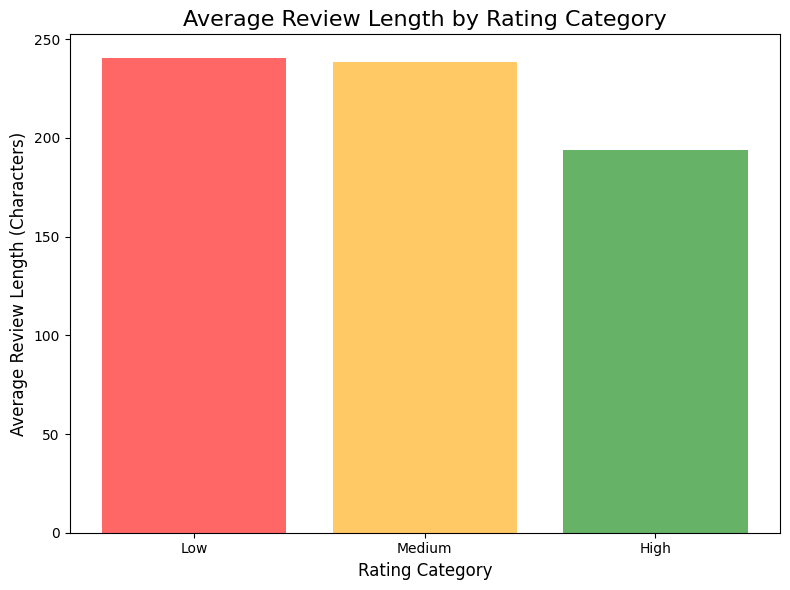

In [13]:
# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(result_pdf["Rating Category"], result_pdf["Average Review Length"], alpha=0.6, color=['red', 'orange', 'green'])
plt.title("Average Review Length by Rating Category", fontsize=16)
plt.xlabel("Rating Category", fontsize=12)
plt.ylabel("Average Review Length (Characters)", fontsize=12)
plt.tight_layout()

# Show it
plt.show()

# Count of each rating scores

In [14]:
rating_dist = combined_df.groupBy("rating").count().orderBy("rating")
rating_dist.show()

+------+-----+
|rating|count|
+------+-----+
|   1.0|   77|
|   2.0|   53|
|   3.0|  102|
|   4.0|  157|
|   5.0|  614|
+------+-----+



In [15]:
# Convert to df
rating_dist_data = rating_dist.collect()
rating_dist_pdf = pd.DataFrame(rating_dist_data, columns=["Rating", "Count"])

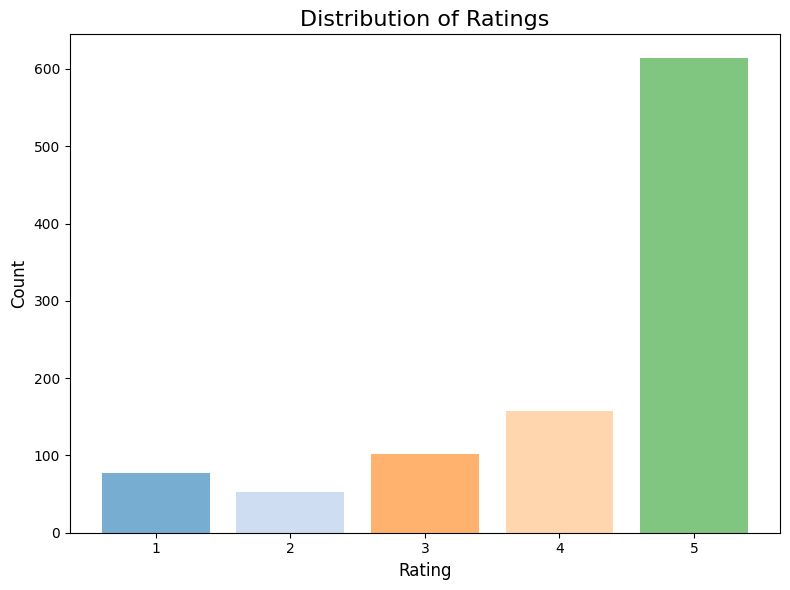

In [16]:
# Bar chart
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(range(len(rating_dist_pdf)))  # Generate different colors for each bar
plt.bar(rating_dist_pdf["Rating"], rating_dist_pdf["Count"], color=colors, alpha=0.6)
plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rating_dist_pdf["Rating"], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show it
plt.show()

# Count of Verified Purchase

In [17]:
from pyspark.sql.functions import col

# Filter the DataFrame for verified purchases
verified_df = combined_df.filter(col('verified_purchase') == 'true')

In [18]:
verified_df.show()

+----------+------------+--------------------+------------------+------+--------------------+-------------+--------------------+--------------------+-----------------+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+------+-------------+----------+--------------------+----------------+---------------+
|      asin|helpful_vote|              images|review_parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase| main_category|               title|average_rating|rating_number|            features|         description| price|              images|videos|        store|categories|             details|meta_parent_asin|bought_together|
+----------+------------+--------------------+------------------+------+--------------------+-------------+--------------------+--------------------+-----------------+--------------+--------------------+--------------+----

In [19]:
# Count the total number of verified and non-verified reviews
# computationally faster than filtering for false
total_verified_reviews = verified_df.count()
total_reviews = combined_df.count()
non_verified_reviews = total_reviews - total_verified_reviews

In [20]:
# DF for visualization
data = {'Category': ['Verified Reviews', 'Non-Verified Reviews'],
        'Count': [total_verified_reviews, non_verified_reviews]}
df = pd.DataFrame(data)

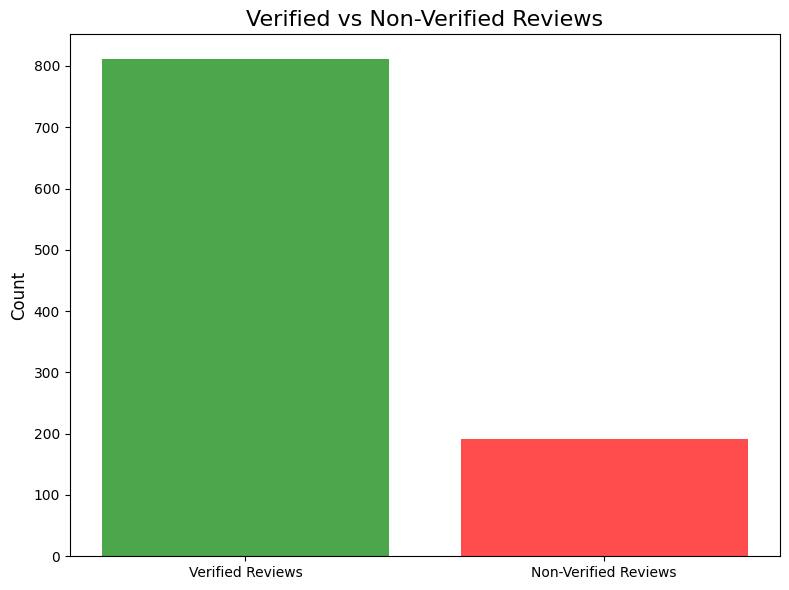

In [21]:
plt.figure(figsize=(8, 6))
plt.bar(df['Category'], df['Count'], alpha=0.7, color=['green', 'red'])
plt.title('Verified vs Non-Verified Reviews', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the bar plot
plt.show()

# Average Title Length by Review

In [33]:
augmented_rdd = (
    reviews_rdd
    .map(
        lambda record: (
            record["rating"], 
            len(record["title"])
        )
    )
)

In [34]:
grouped_rdd = augmented_rdd.groupByKey()
average_rdd = grouped_rdd.mapValues(lambda lengths: sum(lengths) / len(lengths))
result = average_rdd.collect()

ratings, avg_title_length = zip(*result)

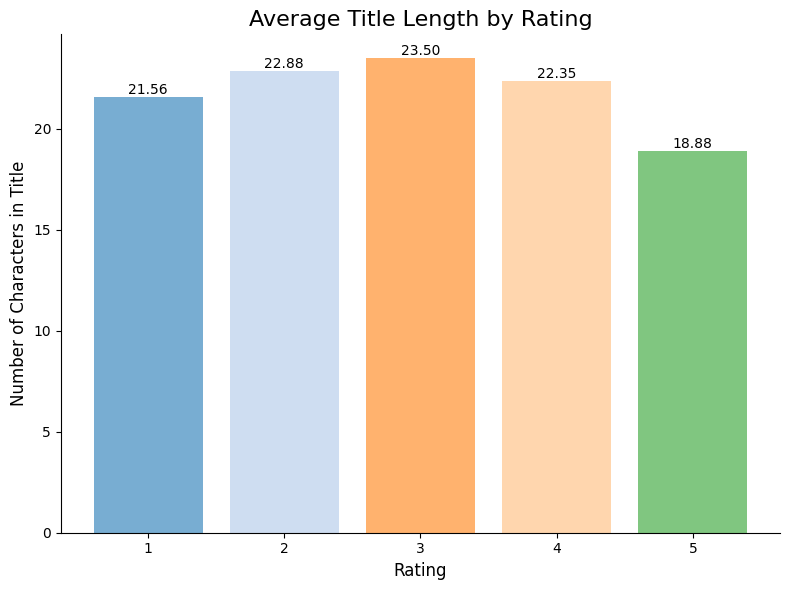

In [39]:
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(range(len(avg_title_length))) 
bars = plt.bar(ratings, avg_title_length, color=colors, alpha=0.6)

for bar, value in zip(bars, avg_title_length):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}", 
        ha="center", va="bottom", fontsize=10 
    )

plt.title("Average Title Length by Rating", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Number of Characters in Title", fontsize=12)
plt.xticks(ratings, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 
plt.tight_layout()
plt.show()

In [22]:
sc.stop()